In [1]:
from DeepDynamics import DeepDynamics as DD
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
#from numba import njit
from scipy.integrate import odeint

In [2]:
import tensorflow as tf
print( tf.__version__ )
print( tf.config.list_physical_devices() )

2.7.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [3]:
dt = .001
t = np.arange(0, 20, dt)

In [4]:
sigma = 10
beta = 8/3
rho = 28
#@njit
def lorenz(t, x, sigma, beta, rho):
    x1 = sigma * (x[1] - x[0])
    x2 = x[0] * (rho - x[2]) - x[1]
    x3 = x[0] * x[1] - beta * x[2]
    return [x1, x2, x3]

In [5]:
#@njit
def lorenz2(x, t):
    sigma = 10
    beta = 8/3
    rho = 28
    x1 = sigma * (x[1] - x[0])
    x2 = x[0] * (rho - x[2]) - x[1]
    x3 = x[0] * x[1] - beta * x[2]
    return [x1, x2, x3]

In [6]:
X_star = odeint(lorenz2, [1,1,1], t)
skip = 1
X_train = X_star[0::skip,:]
#X_train = np.array([x, y, x]).T
X_train = np.reshape(X_train, (1,X_train.shape[0], X_train.shape[1]))
w = np.random.normal(0, 1, X_train.shape)
X_train = X_train + w
X_train = [X_train]

In [7]:
layers = [3, 256, 3]
noise_reg_param = 1e-2
weight_reg_param = 1e-2
smoothening_param = 0
rk_steps = 2
model = DD(dt, X_train, layers, 
                   noise_reg_param=noise_reg_param,
                   weight_reg_param=weight_reg_param,
                   smoothening_param=smoothening_param,
                   rk_steps=rk_steps)

In [8]:
epochs = 10_000
iters = 1
model.train(epochs, iters)

Epoch: 1, Loss: 2.000e+00, Time: 1.33
Epoch: 1000, Loss: 2.294e-01, Time: 228.36
Epoch: 2000, Loss: 4.416e-02, Time: 459.05
Epoch: 3000, Loss: 1.753e-02, Time: 698.32
Epoch: 4000, Loss: 1.243e-02, Time: 937.14
Epoch: 5000, Loss: 1.095e-02, Time: 1167.05
Epoch: 6000, Loss: 1.037e-02, Time: 1394.42
Epoch: 7000, Loss: 1.011e-02, Time: 1624.30
Epoch: 8000, Loss: 9.976e-03, Time: 1853.29
Epoch: 9000, Loss: 9.912e-03, Time: 2080.35
Epoch: 10000, Loss: 9.882e-03, Time: 2307.99


In [9]:
model.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               1024      
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 1,795
Trainable params: 1,795
Non-trainable params: 0
_________________________________________________________________


In [10]:
def learned_f(t, x):
    return model.predict(x)

In [11]:
x0_test = np.array([2,3,4])

In [12]:
learned_X = solve_ivp(learned_f, t_span=(t[0], t[-1]), y0=x0_test, t_eval=t)

Text(0.5, 0, 'z')

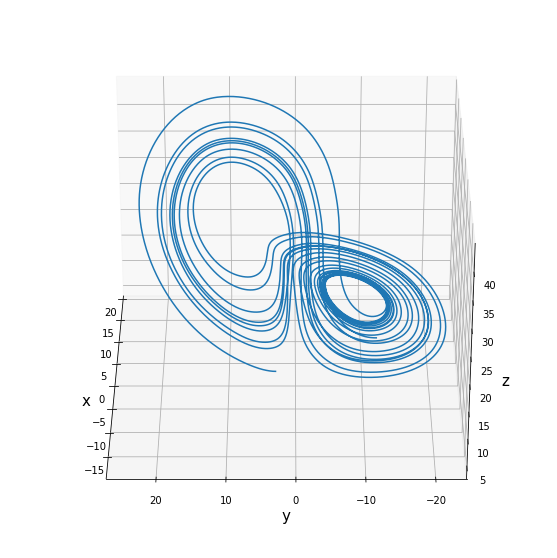

In [13]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot(learned_X.y[0], learned_X.y[1], learned_X.y[2])
ax.view_init(30, 180)
ax.set_xlabel("x", size=15); ax.set_ylabel("y", size=15); ax.set_zlabel("z", size=15)

In [14]:
true_X = solve_ivp(lorenz, t_span=(t[0], t[-1]), y0=x0_test, t_eval=t, args=(sigma, beta, rho))

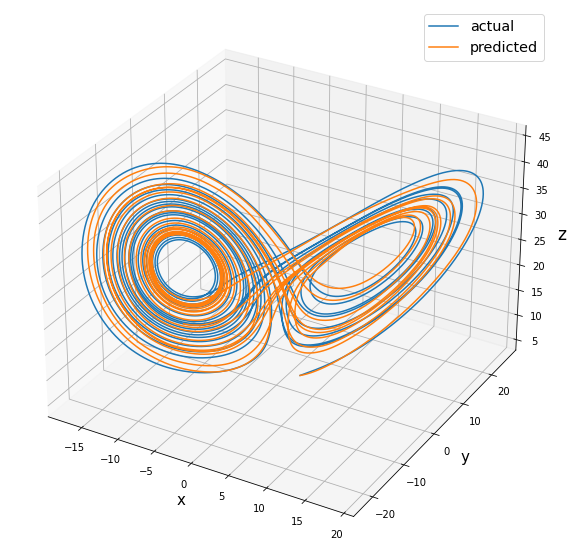

In [26]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1, 1, 1, projection='3d')
ax1.plot(true_X.y[0], true_X.y[1], true_X.y[2], label="actual")
ax1.plot(learned_X.y[0], learned_X.y[1], learned_X.y[2], label="predicted")
ax1.set_xlabel("x", size=15); ax1.set_ylabel("y", size=15); ax1.set_zlabel("z", size=17); 
#ax1.set_title("Actual Trajectory", size=20)
plt.legend(fontsize='x-large')
#ax2 = fig.add_subplot(1, 2, 2, projection='3d')
#ax2.plot(learned_X.y[0], learned_X.y[1], learned_X.y[2])
#ax2.view_init(30, 180)
#ax2.set_xlabel("x", size=15); ax2.set_ylabel("y", size=15); ax2.set_zlabel("z", size=15)
#ax2.set_title("Predicted Trajectory", size=20)

In [27]:
model.w_storage

[<tf.Tensor: shape=(1, 20000, 3), dtype=float32, numpy=
 array([[[ 0.44069004, -1.0494487 ,  0.9767496 ],
         [-0.3352591 , -0.5751406 ,  0.44591823],
         [ 0.8313252 , -0.48086676, -0.4101073 ],
         ...,
         [-0.6429097 , -0.75200576, -0.3564888 ],
         [-0.16663375, -0.26173395, -1.5263293 ],
         [-1.0486498 ,  0.9718487 ,  0.25056577]]], dtype=float32)>]

In [28]:
tf.math.reduce_std(model.w_storage[0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.9741344>

In [29]:
X_tr = X_star[0::skip,:]
#X_train = np.array([x, y, x]).T
X_tr = np.reshape(X_tr, (1,X_tr.shape[0], X_tr.shape[1]))
w = X_train - X_tr

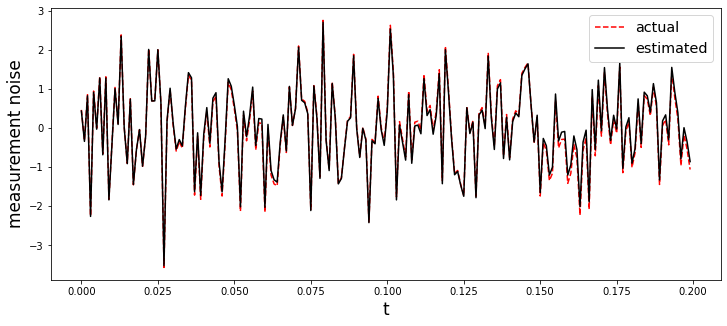

In [32]:
plt.figure(figsize=(12,5))
plt.plot(t[:200], w[0,0,:200,0], label="actual", color="red", linestyle="--")
plt.plot(t[:200], np.array(model.w_storage[0])[0,:200,0], label="estimated", color="k")
plt.ylabel("measurement noise", size=17)
plt.xlabel("t", size=17)
plt.legend(fontsize="x-large")

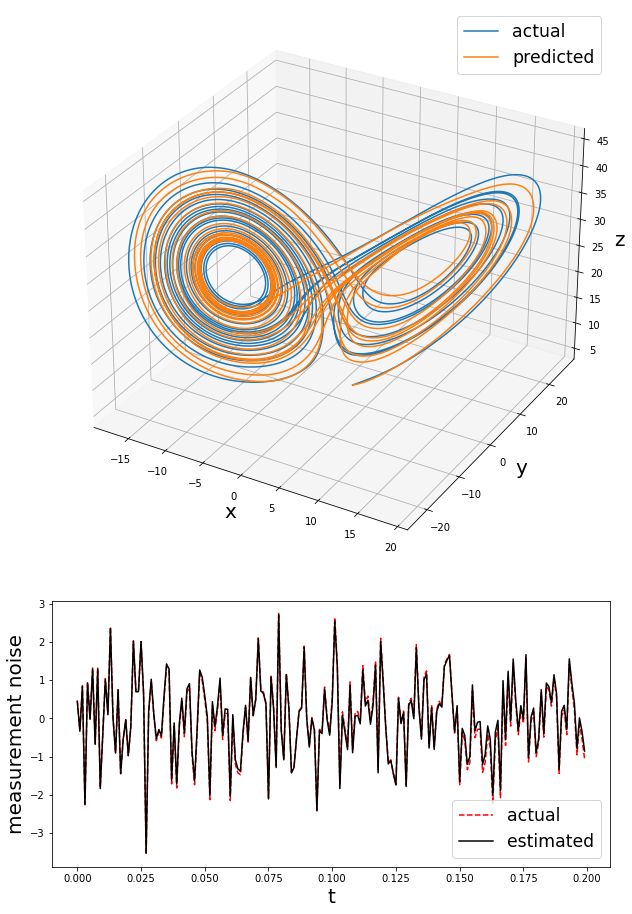

In [59]:
fig = plt.figure(figsize=(10,20))
fig.patch.set_facecolor('white')
ax1 = fig.add_subplot(2, 1, 1, projection='3d')
ax1.plot(true_X.y[0], true_X.y[1], true_X.y[2], label="actual")
ax1.plot(learned_X.y[0], learned_X.y[1], learned_X.y[2], label="predicted")
ax1.set_xlabel("x", size=20); ax1.set_ylabel("y", size=20); ax1.set_zlabel("z", size=20); 
#ax1.set_title("Actual Trajectory", size=20)
ax1.legend(fontsize='xx-large')
ax2 = fig.add_subplot(2, 1, 2, aspect=.015)
ax2.plot(t[:200], w[0,0,:200,0], label="actual", color="red", linestyle="--")
ax2.plot(t[:200], np.array(model.w_storage[0])[0,:200,0], label="estimated", color="k")
ax2.set_ylabel("measurement noise", size=20)
ax2.set_xlabel("t", size=20)
ax2.legend(fontsize="xx-large")
plt.subplots_adjust(hspace = -.3)